In [1]:
import numpy as np
import healpy as hp
from beamconv import ScanStrategy
%matplotlib inline

In [2]:
import qpoint as qp
print(qp.__file__)

/Users/personal/.local/lib/python3.7/site-packages/qpoint/__init__.py


We start by defining our horizon: a 290K source that occupies a little more than half the sky with sinusoidal elevation.

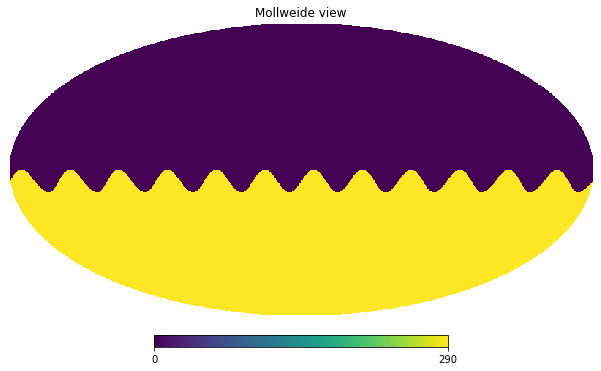

In [3]:
nside = 512
lmax = 700
pixels = np.arange(hp.nside2npix(nside))#all pixels of the healpix map
theta, phi = hp.pix2ang(nside, pixels)#all pixel coordinates 

ground = np.zeros(hp.nside2npix(nside))
ground[theta>(np.pi/2+.1*(np.sin(12*phi)+1))]=290.#horizon condition
alm = hp.map2alm([ground, np.zeros(hp.nside2npix(nside)), np.zeros(hp.nside2npix(nside))], 
                                lmax = lmax)
hp.mollview(ground)

If we look at the auto spectra, there's quite a lot of ringing due to the 'evenness' of the division

Text(0, 0.5, '$D_\\ell^{TT}$ $(K^2)$')

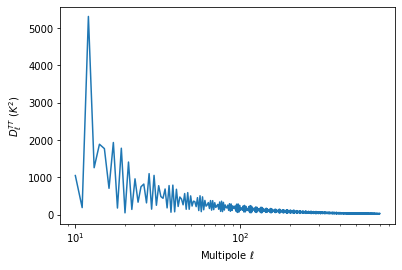

In [4]:
import matplotlib.pyplot as plt

ell = np.arange(lmax+1)
plt.semilogx(ell[10:], ell[10:]*(ell+1)[10:]*hp.anafast(ground, lmax=lmax)[10:]/2/np.pi)
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$D_\ell^{TT}$ $(K^2)$')

We also create a beam: it is the sum of two Gaussians, one narrow which is the main beam and one much weaker playing the role of the sidelobes.

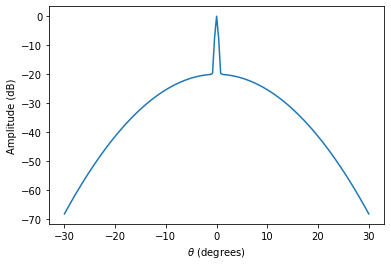

In [5]:
fwhm = np.radians(.5)#main beam, 30 arcmin
side_fwhm = np.radians(15)#sidelobe, 15 degree fwhm!
#1d example
tht = np.linspace(-np.pi/6, np.pi/6, 151)
beam_1d =  0.99*np.exp(-tht**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-tht**2/(2*(side_fwhm/2.355)**2))
#beam_1d =  np.exp(-tht**2/(2*(fwhm/2.355)**2))
plt.plot(tht/np.pi*180., 10*np.log10(beam_1d))
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('Amplitude (dB)')
#Now the full sky-beam
beam = 0.99*np.exp(-theta**2/(2*(fwhm/2.355)**2))+0.01*np.exp(-theta**2/(2*(side_fwhm/2.355)**2))
#beam = np.exp(-theta**2/(2*(fwhm/2.355)**2))
blm = hp.map2alm([beam, beam, np.zeros(hp.nside2npix(nside))], lmax=lmax, mmax=lmax)
np.save('./ancillary/gaussian_with_sidelobe', blm, allow_pickle=True)

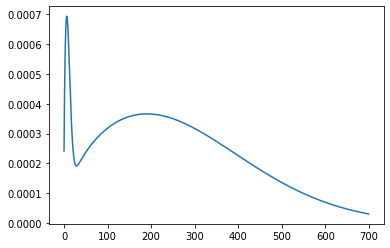

In [6]:
plt.plot(np.absolute(blm[0, hp.Alm.getidx(700, np.arange(700),0)]))

Now for the proper beamconv part: we define beam options for a single detector, and a scan strategy using our ground_scan keyword.

In [7]:
#Beam options
import pickle
beam_file = './ancillary/beam_opts_ssn.pkl'
beam_opts = dict(az=0,
                 el=0,
                 polang=0.,
                 btype='PO',
                 name='SingleDet',
                 lmax=lmax,
                 mmax=lmax,
                 amplitude=1.,
                 po_file='./ancillary/gaussian_with_sidelobe.npy',
                 deconv_q=True,                       
                 normalize=True)
with open(beam_file, 'wb') as handle:
    pickle.dump(beam_opts, handle, protocol=pickle.HIGHEST_PROTOCOL)

#Scan strategy:

az_throw   = 360.
scan_speed = 0.01
rot_period = 12*60*60
nside_spin = nside
nsamp=3600*24
az0 = 0.
el0 = 10.
# init scan strategy and instrument
sata = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 1 Hz sample rate                                    
                  location='atacama') # Atacama instrument
sata.load_focal_plane('./ancillary', no_pairs=True)


#Pointing
import time
t0 = time.time()
qpo = qp.QPoint()
ra0, dec0, _, _ = qpo.azel2radec(0,0,0, [az0], [el0], [0.], [0.], [-67.78], [-22.95], [t0])
print(ra0, dec0)

sata.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                       scan_speed=scan_speed, el_min=0, check_interval=nsamp)#Reduce repointing that way
sata_tod = sata.tod.copy()
sata_pix = sata.pix.copy()

#Redo but at south pole
spole = ScanStrategy(nsamp, # mission duration in sec.                                  
                  sample_rate=1, # 100 Hz sample rate                                    
                  location='spole') # South pole instrument
spole.load_focal_plane('./ancillary', no_pairs=True)
ra0, dec0, _, _ = qpo.azel2radec(0,0,0,[az0], [el0], [0.], [0.], [+180.], [-90.], [t0])
print(ra0, dec0)
spole.scan_instrument_mpi(alm, verbose=1, ra0=ra0, dec0=dec0, az_throw=az_throw,
                       nside_spin=nside_spin, max_spin=5, binning=False, ground_scan=True, 
                          scan_speed=scan_speed, el_min=0, check_interval=nsamp)#Reduce repointing that way
spole_tod = spole.tod.copy()
spole_pix = spole.pix.copy()

[37.45776733] [56.95947208]
Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB
[rank 000]:	Working on chunk 000: samples 0-86400
el start 9.992000, el end 9.992000
az start 0.003316, az end 143.993316
[-74.68600168] [-10.03017732]
Scanning with 2 detectors
[rank 000]: working on: SingleDetA, SingleDetB


/Users/personal/.local/lib/python3.7/site-packages/qpoint/_libqpoint.py:707: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  arg.flags['WRITEABLE'] << 2 |


[rank 000]:	Working on chunk 000: samples 0-86400
el start 10.098216, el end 10.098216
az start 10.839083, az end 154.829083


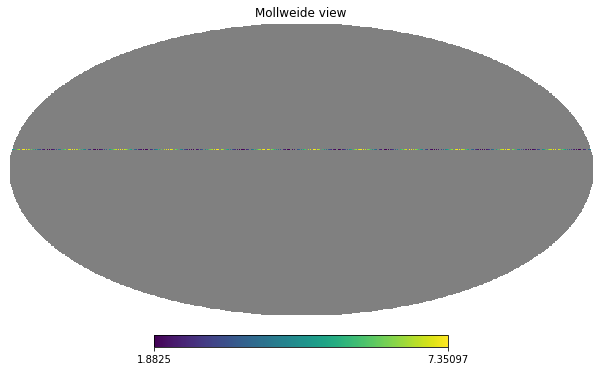

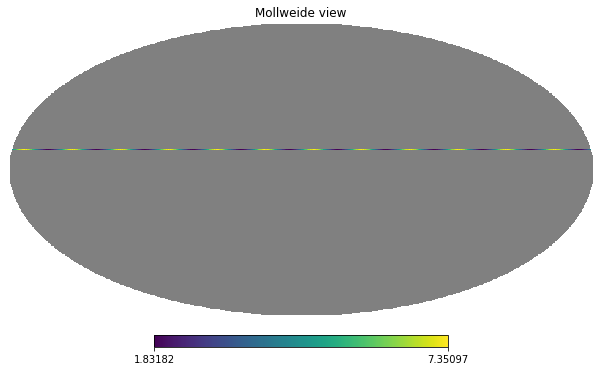

In [8]:
masked_map = np.ones(hp.nside2npix(nside))*hp.UNSEEN
masked_map[sata_pix]=sata_tod
hp.mollview(masked_map)
masked_map = np.ones(hp.nside2npix(nside))*hp.UNSEEN
masked_map[spole_pix]=spole_tod
hp.mollview(masked_map)

Average el spole: 10.098260879696227
Average el atacama: 9.99198654271451


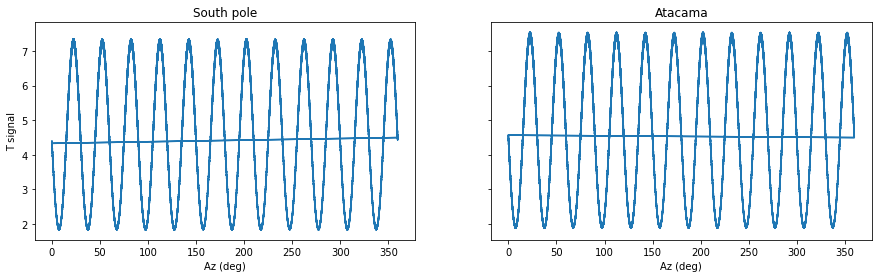

In [9]:
az_pole, el_pole = hp.pix2ang(nside, spole_pix, lonlat=True)
az_ata, el_ata = hp.pix2ang(nside, sata_pix, lonlat=True)
fig, ax= plt.subplots(1,2, sharey='all', figsize=(15,4))
ax[0].plot(az_pole, spole_tod)
ax[1].plot(az_ata, sata_tod)
ax[0].set_ylabel('T signal')
ax[0].set_xlabel('Az (deg)')
ax[1].set_xlabel('Az (deg)')
ax[0].set_title('South pole')
ax[1].set_title('Atacama')

print('Average el spole: {}'.format(np.average(el_pole)))
print('Average el atacama: {}'.format(np.average(el_ata)))